In [26]:
#type:ignore
import pandas as pd
import numpy as np
from keras.applications import VGG16
from keras.layers import Conv2D
from keras.models import Model
import pathlib
import os
from xml.etree import ElementTree as ET
import cv2
import matplotlib.pyplot as plt
import json
import ast

In [27]:
def anchor_boxes(image_size,grids_size,aspect_ratios):

    image_width, image_height, _ = image_size

    grid_width = image_width//grids_size[0]
    grid_height = image_height//grids_size[1]

    grid_center_x_start = grid_width//2
    grid_center_x_end = int((grids_size[0] - 0.5)*grid_width) 

    grid_center_x = np.linspace(grid_center_x_start,grid_center_x_end,grids_size[0])

    grid_center_y_start = grid_height//2
    grid_center_y_end = int((grids_size[1] - 0.5)*grid_height)

    grid_center_y = np.linspace(grid_center_y_start,grid_center_y_end,grids_size[1])

    grid_center_x_mesh, grid_center_y_mesh = np.meshgrid(grid_center_x,grid_center_y)

    grid_center_x_mesh = np.expand_dims(grid_center_x_mesh,-1)
    grid_center_y_mesh = np.expand_dims(grid_center_y_mesh,-1)

    anchor_boxes_no = len(aspect_ratios)

    anchor_boxes_tensor = np.zeros((grids_size[0],grids_size[1],anchor_boxes_no,4))

    anchor_boxes_tensor[...,0] = np.tile(grid_center_x_mesh,(1,1,anchor_boxes_no))
    anchor_boxes_tensor[...,1] = np.tile(grid_center_y_mesh,(1,1,anchor_boxes_no))

    anchor_box_width_height = list()

    for aspect_ratio in aspect_ratios:

        anchor_box_width_height.append((158*np.sqrt(aspect_ratio),
                                        173/np.sqrt(aspect_ratio)))
        
    anchor_box_width_height = np.array(anchor_box_width_height)

    anchor_boxes_tensor[...,2] = anchor_box_width_height[:,0]
    anchor_boxes_tensor[...,3] = anchor_box_width_height[:,1]

    return anchor_boxes_tensor

In [28]:
def centroid2minmax(anchor_boxes_centroid_tensor):

    anchor_boxes_minmax_tensor = np.copy(anchor_boxes_centroid_tensor)

    anchor_boxes_minmax_tensor[...,0] = anchor_boxes_minmax_tensor[...,0] - (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,1] = anchor_boxes_minmax_tensor[...,1] - (anchor_boxes_minmax_tensor[...,3]//2)
    anchor_boxes_minmax_tensor[...,2] = anchor_boxes_minmax_tensor[...,0] + (anchor_boxes_minmax_tensor[...,2]//2)
    anchor_boxes_minmax_tensor[...,3] = anchor_boxes_minmax_tensor[...,1] + (anchor_boxes_minmax_tensor[...,3]//2)

    return anchor_boxes_minmax_tensor

In [29]:
def compute_IoU(anchor_boxes_minmax_tensor,image_gt_bbox_coords):

    image_gt_bbox_centroid_coords = np.array(image_gt_bbox_coords)
    image_gt_bbox_centroid_coords[:,0] = image_gt_bbox_centroid_coords[:,0] +\
                                         (image_gt_bbox_centroid_coords[:,2] - image_gt_bbox_centroid_coords[:,0])//2
    image_gt_bbox_centroid_coords[:,1] = image_gt_bbox_centroid_coords[:,1] +\
                                         (image_gt_bbox_centroid_coords[:,3] - image_gt_bbox_centroid_coords[:,1])//2
    image_gt_bbox_centroid_coords[:,2] = (image_gt_bbox_centroid_coords[:,2] - image_gt_bbox_centroid_coords[:,0])
    image_gt_bbox_centroid_coords[:,3] = (image_gt_bbox_centroid_coords[:,3] - image_gt_bbox_centroid_coords[:,1]) 
    
    IoU_tensor = np.zeros((len(image_gt_bbox_coords),anchor_boxes_minmax_tensor.shape[0],anchor_boxes_minmax_tensor.shape[1],
                    anchor_boxes_minmax_tensor.shape[2]))
    bbox_present_idxes = [[]]*len(image_gt_bbox_coords) 
    IoU_thresh = 0.25

    for i in range(len(image_gt_bbox_coords)):

        for j in range(anchor_boxes_minmax_tensor.shape[2]):
            """
            centroid_x_condition_anchor_boxes = ((image_gt_bbox_centroid_coords[i,0] > anchor_boxes_minmax_tensor[:,:,j,0]) & 
                                               (image_gt_bbox_centroid_coords[i,0] < anchor_boxes_minmax_tensor[:,:,j,2]))
            centroid_y_condition_anchor_boxes = ((image_gt_bbox_centroid_coords[i,1] > anchor_boxes_minmax_tensor[:,:,j,1]) & 
                                               (image_gt_bbox_centroid_coords[i,1] < anchor_boxes_minmax_tensor[:,:,j,3]))
            grid_cells_idxes = np.argwhere(centroid_x_condition_anchor_boxes & centroid_y_condition_anchor_boxes)
            bbox_present_idxes[i].append(grid_cells_idxes)
            """

            xmin_intersection = np.maximum(image_gt_bbox_coords[i][0],anchor_boxes_minmax_tensor[:,:,j,0])
            ymin_intersection = np.maximum(image_gt_bbox_coords[i][1],anchor_boxes_minmax_tensor[:,:,j,1])

            xmax_intersection = np.minimum(image_gt_bbox_coords[i][2],anchor_boxes_minmax_tensor[:,:,j,2])
            ymax_intersection = np.minimum(image_gt_bbox_coords[i][3],anchor_boxes_minmax_tensor[:,:,j,3])

            intersection_width = np.maximum(0,(xmax_intersection - xmin_intersection))
            intersection_height = np.maximum(0,(ymax_intersection - ymin_intersection))

            intersection_area = intersection_width * intersection_height

            image_gt_bbox_area = image_gt_bbox_centroid_coords[i,2] * image_gt_bbox_centroid_coords[i,3]
            anchor_boxes_width = (anchor_boxes_minmax_tensor[:,:,j,2] - anchor_boxes_minmax_tensor[:,:,j,0])
            anchor_boxes_height = (anchor_boxes_minmax_tensor[:,:,j,3] - anchor_boxes_minmax_tensor[:,:,j,1])

            union_area = ((anchor_boxes_width * anchor_boxes_height) + image_gt_bbox_area) - intersection_area

            IoU_tensor[i,:,:,j] = intersection_area/union_area
            bbox_present_idxes[i].append(np.argwhere(IoU_tensor[i,:,:,j] > 0))
            #print("IoU_tensor for IoU of {}th Anchor Box with the GT Bounding Box of Object # {} is {}".format(j+1,i+1, IoU_tensor[i,:,:,j]))

    IoU_tensor_reduced = np.max(IoU_tensor,axis=0)
    anchor_boxes_gt_mask = np.float64(IoU_tensor_reduced > IoU_thresh)

    return image_gt_bbox_centroid_coords, anchor_boxes_gt_mask, bbox_present_idxes, IoU_tensor_reduced

In [30]:
def normalize_bbox_coords(image_size,amchor_boxes_gt_mask,bbox_present_idxes,image_gt_bbox_centroid_coords,anchor_boxes_minmax_tensor):

    image_width, image_height, _ = image_size
    normalized_image_gt_bbox_coords = np.zeros_like(anchor_boxes_minmax_tensor)

    for i in range(len(image_gt_bbox_centroid_coords)):
    
        for j in range(anchor_boxes_minmax_tensor.shape[2]):

            idx = bbox_present_idxes[i][j]

            normalized_image_gt_bbox_coords[idx[:,0],idx[:,1],j,0] = image_gt_bbox_centroid_coords[i][0]/anchor_boxes_minmax_tensor[idx[:,0],idx[:,1],j,2]
            normalized_image_gt_bbox_coords[idx[:,0],idx[:,1],j,1] = image_gt_bbox_centroid_coords[i][1]/anchor_boxes_minmax_tensor[idx[:,0],idx[:,1],j,3]
            normalized_image_gt_bbox_coords[idx[:,0],idx[:,1],j,2] = image_gt_bbox_centroid_coords[i][2]/image_width
            normalized_image_gt_bbox_coords[idx[:,0],idx[:,1],j,3] = image_gt_bbox_centroid_coords[i][3]/image_height

    return normalized_image_gt_bbox_coords

In [31]:
def create_gt_labels_tensor(normalized_image_gt_bbox_coords, IoU_tensor, bbox_present_idxes, image_cls_labels, num_classes):

    cls_probabilities_tensor = np.zeros((normalized_image_gt_bbox_coords.shape[0],normalized_image_gt_bbox_coords.shape[1],num_classes))

    for i in range(len(bbox_present_idxes)):
        idx_0 = bbox_present_idxes[i][0]
        idx_1 = bbox_present_idxes[i][1]
        cls_probabilities_tensor[idx_0[:,0],idx_0[:,1],:] = np.eye(num_classes,num_classes)[image_cls_labels[i]]
        cls_probabilities_tensor[idx_1[:,0],idx_1[:,1],:] = np.eye(num_classes,num_classes)[image_cls_labels[i]]

    gt_labels_tensor = np.copy(normalized_image_gt_bbox_coords)
    confidence_scores = np.expand_dims(IoU_tensor,-1)
    gt_labels_tensor = np.concatenate((gt_labels_tensor,confidence_scores),axis=3)
    gt_labels_tensor = gt_labels_tensor.reshape(gt_labels_tensor.shape[0],gt_labels_tensor.shape[1],gt_labels_tensor.shape[2]*gt_labels_tensor.shape[3])
    gt_labels_tensor = np.concatenate((gt_labels_tensor,cls_probabilities_tensor),axis=2)
    
    return gt_labels_tensor

In [32]:
def object_detection_cnn():

    vgg16 = VGG16(include_top=False,input_shape=(480,640,3),weights="imagenet",pooling=None)
    vgg16.trainable = False
    input_to_vgg16 = vgg16.input
    vgg16_output = Conv2D(filters=30,kernel_size=(9,14),activation="relu")(vgg16.layers[-1].output)

    return Model(inputs=[input_to_vgg16],outputs=[vgg16_output])

In [33]:
yolov1_cnn = object_detection_cnn()

In [34]:
yolov1_cnn.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 480, 640, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 480, 640, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 480, 640, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 240, 320, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 240, 320, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 240, 320, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 120, 160, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 120, 160, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 120, 160, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 120, 160, 256)  │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 60, 80, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 60, 80, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 60, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 60, 80, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 30, 40, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 30, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 30, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 30, 40, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 15, 20, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 30)       │     1,935,390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,650,078 (63.52 MB)

 Trainable params: 1,935,390 (7.38 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [35]:
def train_test_df(imgs_base_path,annotations_base_path):

    img_complete_paths = list()
    img_class_labels = list()
    img_gt_bbox_coords = list()

    for single_img_complete_path in pathlib.Path(imgs_base_path).glob("*"):

        img_path = str(single_img_complete_path)
        img_label_path = os.path.join(annotations_base_path,str(single_img_complete_path).split("/")[-1].split(".")[0]+".xml")

        class_gt_labels_list = list()
        gt_bbox_coords_list = list()

        tree = ET.parse(img_label_path)
        root = tree.getroot()

        for member in root.findall("object"):
            
            class_gt_labels_list.append(member.find("name").text)
            xmin = float(member.find("bndbox/xmin").text)
            ymin = float(member.find("bndbox/ymin").text)
            xmax = float(member.find("bndbox/xmax").text)
            ymax = float(member.find("bndbox/ymax").text)
            
            #bbox_width = xmax - xmin
            #bbox_height = ymax - ymin
            
            gt_bbox_coords_list.append([xmin,ymin,xmax,ymax])

        img_complete_paths.append(str(single_img_complete_path))
        img_class_labels.append(class_gt_labels_list)
        img_gt_bbox_coords.append(gt_bbox_coords_list)

    return pd.DataFrame(data={"img_path":img_complete_paths,
                              "img_gt_class_labels":img_class_labels,
                              "img_gt_bbox_coords":img_gt_bbox_coords})

In [36]:
data_df = train_test_df("VOCdevkit/VOC2012/JPEGImages","VOCdevkit/VOC2012/Annotations")

In [37]:
unique_labels = set()

for img_labels in data_df.iloc[:,1]:
    unique_labels = unique_labels.union(set(img_labels))

unique_labels = list(unique_labels)
#unique_labels.insert(0,"background")

labels2idx = dict(zip(unique_labels,range(len(unique_labels))))


In [38]:
def labels2idx_mapping(img_labels):

    return list(map(lambda x: labels2idx[x],img_labels))

In [39]:
data_df.iloc[:,1] = data_df.iloc[:,1].apply(labels2idx_mapping)

In [40]:
data_df["img_gt_class_labels"] = data_df["img_gt_class_labels"].apply(json.dumps)
data_df["img_gt_bbox_coords"] = data_df["img_gt_bbox_coords"].apply(json.dumps)

In [41]:
training_data = data_df.iloc[0:15000,:]
cv_data = data_df.iloc[15000:,]

training_data.to_csv("./training_data.csv",index=False)
cv_data.to_csv("./cv_data.csv",index=False)

In [42]:
training_data = pd.read_csv("training_data.csv")
training_data["img_gt_class_labels"] = training_data["img_gt_class_labels"].apply(ast.literal_eval)
training_data["img_gt_bbox_coords"] = training_data["img_gt_bbox_coords"].apply(ast.literal_eval)

In [43]:
plt.imread(training_data.iloc[0,0]).shape

(500, 269, 3)

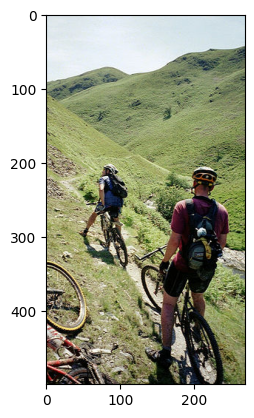

In [44]:
plt.imshow(plt.imread(training_data.iloc[0,0]))

In [45]:
training_data.iloc[0,1]

[2, 2, 2, 5, 5]

In [46]:
training_data.iloc[0,2]

[[117.0, 310.0, 240.0, 500.0],
 [54.0, 253.0, 112.0, 345.0],
 [1.0, 332.0, 91.0, 500.0],
 [134.0, 206.0, 248.0, 479.0],
 [47.0, 202.0, 110.0, 319.0]]

In [47]:
anchor_boxes_tensor = anchor_boxes((640,480,3),(7,7),(1/2,2))
anchor_boxes_minmax_tensor = centroid2minmax(anchor_boxes_tensor)
image_gt_bbox_cenroid_coords, anchor_boxes_gt_mask, bbox_present_idxes,iou_tensor = compute_IoU(anchor_boxes_minmax_tensor,training_data.iloc[0,2])
normalized_gt_bbox_coords = normalize_bbox_coords((640,480,3),anchor_boxes_gt_mask,bbox_present_idxes,image_gt_bbox_cenroid_coords,
                                                  anchor_boxes_minmax_tensor)
gt_labels_tensor = create_gt_labels_tensor(normalized_gt_bbox_coords,iou_tensor,bbox_present_idxes,training_data.iloc[0,1],20)

In [48]:
def custom_data_generator(df,mb_size):

    for i in range(df.shape[0]//mb_size):

        X_train_mb = list()
        Y_train_mb = list()
        GT_mask_train_mb = list()

        for j in range(0,mb_size):

            df_mb = df.iloc[(i*mb_size)+j]
            img_path = df_mb["img_path"]

            X_train_mb.append(cv2.resize(plt.imread(img_path),(640,480)))

            gt_bboxes_mask, iou_tensor = compute_IoU(anchor_boxes_tensor,df_mb["img_gt_bbox_coords"])
            normalized_img_gt_bbox_coords = normalize_bbox_coords((640,480,3),df_mb["img_gt_bbox_coords"],
                                                                  gt_bboxes_mask,anchor_boxes_tensor)
            Y_train, final_gt_bboxes_mask = create_gt_labels_tensor(normalized_img_gt_bbox_coords,iou_tensor,
                                                                    gt_bboxes_mask,df_mb["img_gt_class_labels"],20)
            
            Y_train_mb.append(Y_train)
            GT_mask_train_mb.append(final_gt_bboxes_mask)
            
        yield np.array(X_train_mb), np.array(Y_train_mb), np.array(GT_mask_train_mb)

In [49]:
def custom_loss_fn(Y_true_mb,Y_pred_mb,GT_mask_train_mb,lambda_coord,lambda_noobj):

    squared_error = (Y_true_mb - Y_pred_mb)**2

    """
    squared_error_with_mask = GT_mask_train_mb * squared_error
    squared_error_with_neg_mask = (1.0 - GT_mask_train_mb) * squared_error
    """

    cx_cy_squared_error_tensor = np.concatenate((GT_mask_train_mb*squared_error[:,:,:,0:2],
                                                 GT_mask_train_mb*squared_error[:,:,:,5:7]),axis=0)
    
    sqrt_squared_error = (np.sqrt(Y_true_mb) - np.sqrt(Y_pred_mb))**2

    #sqrt_squared_error_with_mask = GT_mask_train_mb * sqrt_squared_error
    
    wh_sqrt_squared_error_tensor = np.concatenate((GT_mask_train_mb*sqrt_squared_error[:,:,:,2:4],
                                                   GT_mask_train_mb*sqrt_squared_error[:,:,:,7:9]),axis=0)
    
    loss_fn_first_term = lambda_coord*np.sum(cx_cy_squared_error_tensor)
    loss_fn_second_term = lambda_coord*np.sum(wh_sqrt_squared_error_tensor)

    confidence_score_error_tensor = GT_mask_train_mb*np.concatenate((np.expand_dims(squared_error[:,:,:,4],-1),
                                                                     np.expand_dims(squared_error[:,:,:,9],-1)),
                                                                     axis=3)
    
    loss_fn_third_term = np.sum(confidence_score_error_tensor)

    confidence_score_noobj_error_tensor = (1.0 - GT_mask_train_mb)*np.concatenate((np.expand_dims(squared_error[:,:,:,4],-1),
                                                                                   np.expand_dims(squared_error[:,:,:,9],-1)),
                                                                                   axis=3)

    loss_fn_forth_term = lambda_noobj*np.sum(confidence_score_noobj_error_tensor)

    loss_fn_fifth_term = np.sum(GT_mask_train_mb[:,:,:,0]*np.sum(squared_error[:,:,:,10:],axis=3))

    overall_loss_fn = loss_fn_first_term + loss_fn_second_term + loss_fn_third_term +\
                        loss_fn_forth_term + loss_fn_fifth_term
    
    return overall_loss_fn